# Option Pricing and Stochastic Volatility using Neural Network

Understanding the deep-rooted uncertainty in the market volatility is essential for derivatives pricing and risk management. This study will aim introduce the data-driven concept through neural networks to price an option whose volatility is measured as a stochastic process.

In [1]:
import random
import warnings

random.seed(1926159)
warnings.filterwarnings("ignore")

## Simulated Training Data Collection

The simulated data is collected through a method called Euler's discretisation. Euler's discretisation is a simple and intuitive way to approximate the continuous-time dynamics of a stochastic process by breaking it down into discrete time steps.

In [2]:
import numpy as np

m, n, T = 1000, 252, 1

def eulers_discretion_simulation(s0: float, v0: float, kappa: float, theta: float, sigma: float, t: float, m: int, n: int, r: float) -> tuple:
    """
    Inputs:
     - s0, v0: Initial parameters for asset and variance.
     - kappa: Rate of mean reversion in variance process.
     - theta: Long-term mean of variance process.
     - sigma: Vol of vol / volatility of variance process.
     - T: Time of simulation.
     - N: Number of time steps.
     - M: Number of scenarios / simulations.
     - R: Risk Free Rate
    Outputs:
     - S: Asset prices over time (array).
     - V: Variance over time (array).
    """

    dt = t / m
    S = np.zeros((m, n + 1))
    V = np.zeros((m, n + 1))
    np.random.seed(1926159)
    for i in range(m):
        S[i, 0] = s0
        V[i, 0] = v0
        for j in range(1, n + 1):
            Z1 = np.random.randn()
            Z2 = np.random.randn()

            dS = r * S[i, j - 1] * dt + np.sqrt(V[i, j - 1] * dt) * Z1
            dV = kappa * (theta - V[i, j - 1]) * dt + sigma * np.sqrt(V[i, j - 1] * dt) * Z2

            S[i, j] = S[i, j - 1] + dS
            V[i, j] = V[i, j - 1] + dV

    return S, V

S, V = eulers_discretion_simulation(100, 0.04, 10, 10, 2, 1, 252, 10000, 0.03)

count    2.520252e+06
mean     1.895196e+02
std      6.731282e+01
min      8.534778e+01
25%      1.320157e+02
50%      1.765832e+02
75%      2.374955e+02
max      4.221973e+02
dtype: float64


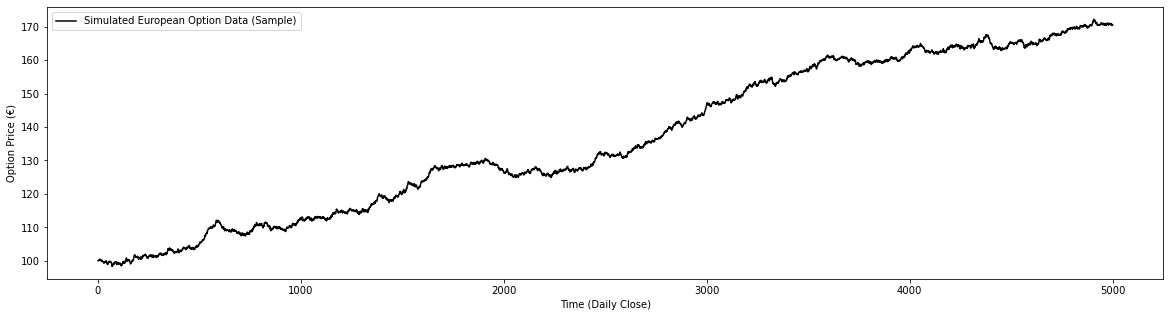

In [3]:
import pandas as pd
import matplotlib.pyplot as plt

option_data = pd.Series(S.flatten())
print(option_data.describe())

x = np.linspace(0, 5000, 5000)
plt.figure(figsize=(20,5))
plt.plot(x, option_data[0:5000], label='Simulated European Option Data (Sample)', c='black')
plt.xlabel("Time (Daily Close)")
plt.ylabel("Option Price (€)")
plt.legend()
plt.show()

## Data Pre-Processing

The Data is split into 80-20 train-validation ratio.

Scaling is applied as normalisation strategy to aid the neural network.

In [4]:
import numpy as np

def format_data(data: list, sequence_length: int) -> tuple:
    """
    Inputs:
    - data: Simulated Heston Data.
    - sequence_length: Considered Time Steps.
    Return:
    - Features and Result.
    """
    x, y = [], []
    for i in range(len(data) - sequence_length):
        x.append(data[i:i+sequence_length])
        y.append(data[i+sequence_length])
    return np.array(x), np.array(y)

In [5]:
sequence_length = 10

flat_S = S.flatten()
flat_S = (flat_S - np.mean(flat_S)) / np.std(flat_S)

split_ratio = 0.8
split_index = int(len(flat_S) * split_ratio)

train_data = flat_S[:split_index]
test_data = flat_S[split_index:]

x_train, y_train = format_data(train_data, sequence_length)
x_test, y_test = format_data(test_data, sequence_length)

## Neural Network Implementation

- Multilayer Perceptron’s (MLP) Feed Forward Network.
- Hidden fully connected layers, each with 100 neurons.
- Batch size of 64.
- 10 training epochs.
- 80-20 train-validation split.
- Mean Squared error as loss function.


In [6]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(100,100,100,100),
    solver='adam',
    shuffle = False,
    batch_size=64,
    verbose=True,
    max_iter= 25
)

## Hyperparameter Tuning

To select the optimal hyperparameters each proposed hyperparameter setting is evaluated against the model and the one that produces the best performance is chosen. In this study hyperparameter tuning will be performed though leveraging a Grid Search integrated with cross-validation.

In [ ]:
from sklearn.model_selection import GridSearchCV

model.get_params()

parameter_space = {
    'activation': ['tanh', 'relu'],
    'alpha': [0.01, 0.05],
    'learning_rate': ['constant','adaptive'],
}

clf = GridSearchCV(model, parameter_space, n_jobs=-1, cv=3)
clf.fit(x_train, y_train)

print('Best parameters found:\n', clf.best_params_)

## Network Training

The process initiates with forward propagation, where input data undergoes a series of transformations.

In [7]:
from sklearn.neural_network import MLPRegressor

model = MLPRegressor(
    hidden_layer_sizes=(100,100,100,100),
    solver='adam',
    shuffle = False,
    batch_size=64,
    verbose=True,
    max_iter= 25,
    activation='relu',
    alpha=0.01,
    learning_rate='constant'
)

model.fit(x_train, y_train)

Iteration 1, loss = 0.00577683
Iteration 2, loss = 0.00232896
Iteration 3, loss = 0.00198278
Iteration 4, loss = 0.00167343
Iteration 5, loss = 0.00160787
Iteration 6, loss = 0.00159724
Iteration 7, loss = 0.00159387
Iteration 8, loss = 0.00164063
Iteration 9, loss = 0.00169292
Iteration 10, loss = 0.00222445
Iteration 11, loss = 0.00231353
Iteration 12, loss = 0.00194905
Iteration 13, loss = 0.00177303
Iteration 14, loss = 0.00169928
Iteration 15, loss = 0.00155633
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


MLPRegressor(alpha=0.01, batch_size=64, hidden_layer_sizes=(100, 100, 100, 100),
             max_iter=25, shuffle=False, verbose=True)

### Sensitivity Analysis

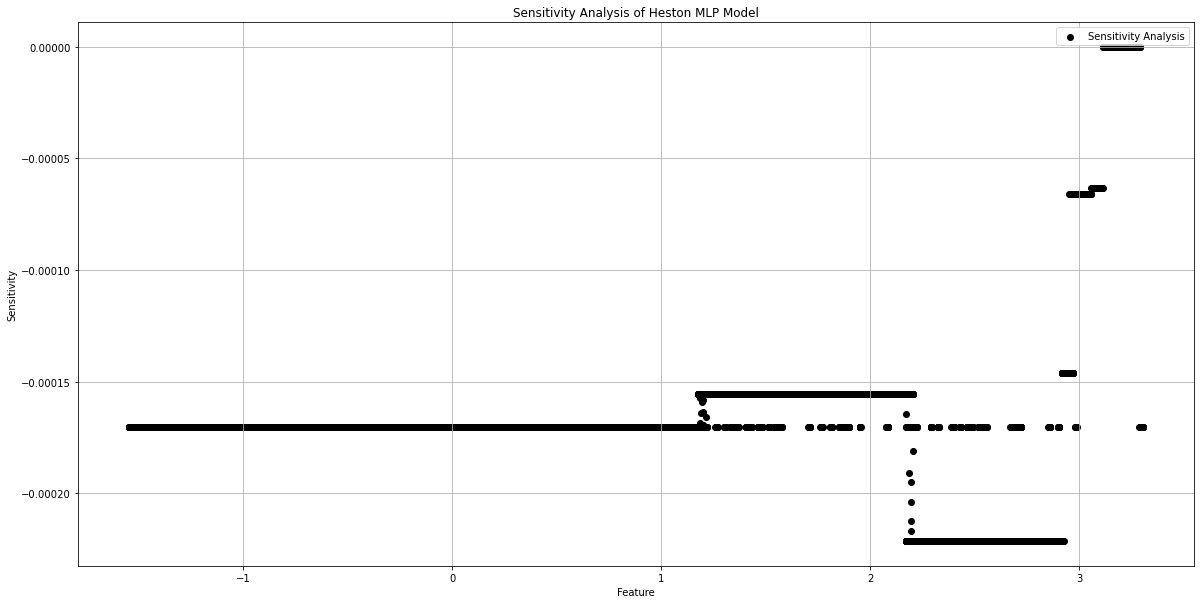

In [8]:
import matplotlib.pyplot as plt

def sensitivity_analysis(model, x) -> list:
    """
    Inputs:
    - model: MLP model.
    - x: Test data.
    Return:
    - Sensitivity of feature.
    """
    baseline_prediction = model.predict(x)
    epsilon = 0.01
    x_perturbed = x.copy()
    x_perturbed[:, 0] += epsilon
    perturbed_prediction = model.predict(x_perturbed)
    sensitivity = perturbed_prediction - baseline_prediction
    return sensitivity

sensitivity = sensitivity_analysis(model, x_test)

plt.figure(figsize=(20, 10))
plt.scatter(x_test[:, 0], sensitivity, label='Sensitivity Analysis', c='black')
plt.xlabel(f'Feature')
plt.ylabel('Sensitivity')
plt.title('Sensitivity Analysis of Heston MLP Model')
plt.legend()
plt.grid(True)
plt.show()

### Download & Upload Model

In [9]:
import pickle

filename = 'neural_network_model.sav'
pickle.dump(model, open(filename, 'wb'))

In [10]:
filename = 'neural_network_model.sav'
model = pickle.load(open(filename, 'rb'))

## Monte Carlo Simulation

The Monte Carlo method is a computational technique used to solve complex mathematical problems by simulating random processes.

count    252252.000000
mean         15.912088
std          57.997613
min           0.000000
25%           0.000000
50%           0.000000
75%           0.000000
max        1769.000000
dtype: float64


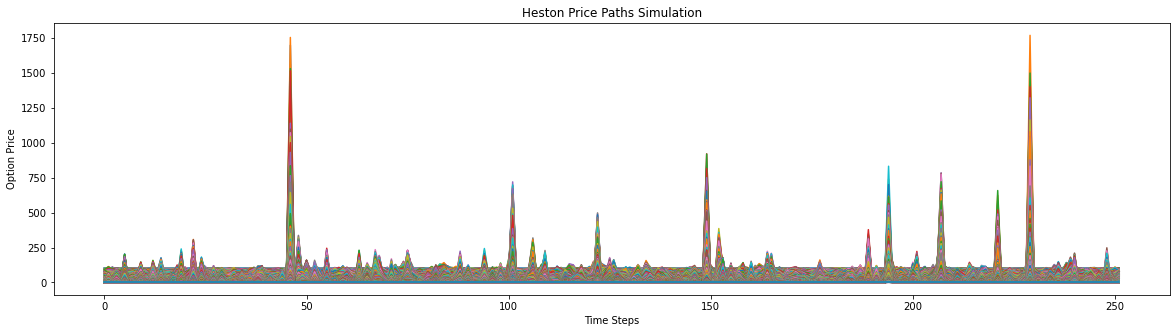

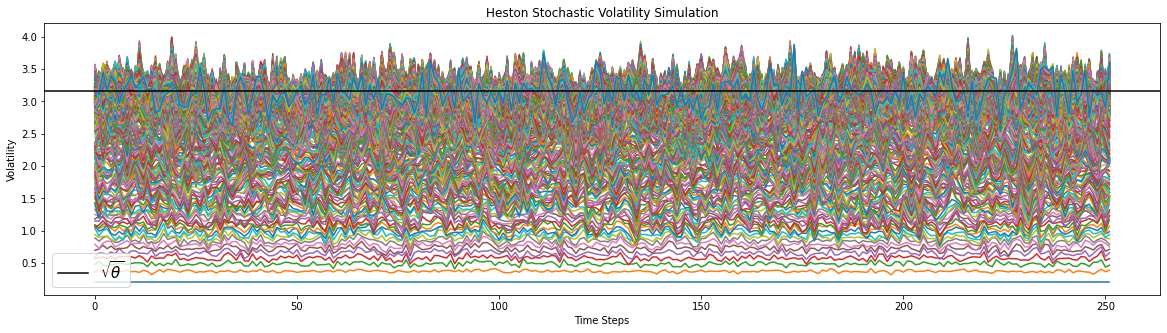

In [11]:
from heston_monte_carlo import heston_model_monte_carlo_simulation

S, V = heston_model_monte_carlo_simulation(100, 0.04, 0, 10, 10, 2, 1, 1000, 252)

option_data = pd.Series(S.flatten())
print(option_data.describe())

plt.figure(figsize=(20,5))
plt.plot(S.T)
plt.title('Heston Price Paths Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Option Price')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(np.sqrt(V).T)
plt.axhline(np.sqrt(10), color='black', label=r'$\sqrt{\theta}$')
plt.title('Heston Stochastic Volatility Simulation')
plt.xlabel('Time Steps')
plt.ylabel('Volatility')
plt.legend(fontsize=15)
plt.show()

In [12]:
sequence_length = 10

flat_S = S.flatten()
flat_S = (flat_S - np.mean(flat_S)) / np.std(flat_S)

split_ratio = 0.8
split_index = int(len(flat_S) * split_ratio)

train_data = flat_S[:split_index]
test_data = flat_S[split_index:]

x_predicted, monte_carlo_y_predicted = format_data(test_data, sequence_length)

## Testing And Analysis

### Error Analysis

In [13]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from math import sqrt
import pandas as pd

neural_network_y_predicted = model.predict(x_test)

def performance_analysis(true: list, predicted: list):
    """
    Inputs:
    - true: The real value.
    - predicted: The model predicted value.
    Return:
    - Results Data Frame.
    """
    mse = mean_squared_error(true, predicted)
    rmse = sqrt(mse)
    mae = mean_absolute_error(true, predicted)
    r2 = r2_score(true, predicted)
    df = {'Mean Squared Error': [mse], 'Root Mean Squared Error': [rmse], 'Mean Absolute Error': [mae], 'R2 Score': [r2]}
    return pd.DataFrame(data=df)

In [14]:
print("Monte Carlo Results:")
print(performance_analysis(y_test[0:50000], monte_carlo_y_predicted[0:50000]))
print("Neural Network Results:")
print(performance_analysis(y_test[0:50000], neural_network_y_predicted[0:50000]))

Monte Carlo Results:
   Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  R2 Score
0            1.413005                 1.188699              0.94302 -0.129961
Neural Network Results:
   Mean Squared Error  Root Mean Squared Error  Mean Absolute Error  R2 Score
0            0.002334                  0.04831             0.020332  0.998134


### Option Pricing

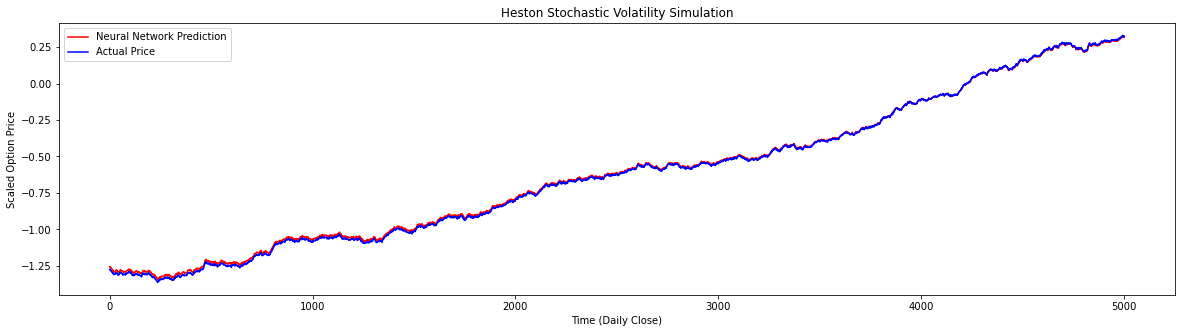

In [15]:
import matplotlib.pyplot as plt

x = np.linspace(0, 5000, 5000)
plt.figure(figsize=(20,5))
plt.plot(x, neural_network_y_predicted[5000:10000], label='Neural Network Prediction', c='r')
plt.plot(x, y_test[5000:10000], label='Actual Price', c='b')
plt.title('Heston Stochastic Volatility Simulation')
plt.xlabel("Time (Daily Close)")
plt.ylabel("Scaled Option Price")
plt.legend()
plt.show()

In [16]:
def take_samples(data: list, n_samples: int) -> dict:
    """
    Inputs:
    - data: The list of data points.
    - n_samples: The number of samples being taken.
    Return:
    - The samples points and the corrasponding values.
    """
    sample_range = len(data)//n_samples
    samples = {}
    x = 0
    for y in range(0, n_samples):
        samples[x] = data[x]
        x += sample_range
    samples[len(data)] = data[len(data)-1]
    return samples